# NEURAL LENGUAGE PROCESSING (NLP)

## OBJECTIVE:
## Implement a system, that it's capable of automatically detecting, whether a web page contains spam or not, based on its URL.

### 0. Data ingestion

In [1]:
import pandas as pd
import missingno as msno
import regex as re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
df_spam = pd.read_csv("url_spam.csv")

### 1. Data information

In [3]:
df_spam.head(7)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
5,https://www.brookings.edu/interactives/reopeni...,False
6,https://www.reuters.com/investigates/special-r...,False


In [4]:
df_spam.shape

(2999, 2)

In [5]:
df_spam.dtypes

url        object
is_spam      bool
dtype: object

In [6]:
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [7]:
missing_values = df_spam.isnull().sum()
missing_values

url        0
is_spam    0
dtype: int64

In [8]:
df_spam.duplicated().sum()

np.int64(630)

In [9]:
df_spam = df_spam.drop_duplicates()
df_spam.shape

(2369, 2)

In [10]:
df_spam["is_spam"].unique()

array([ True, False])

In [11]:
df_spam.isnull().sum()

url        0
is_spam    0
dtype: int64

<Axes: >

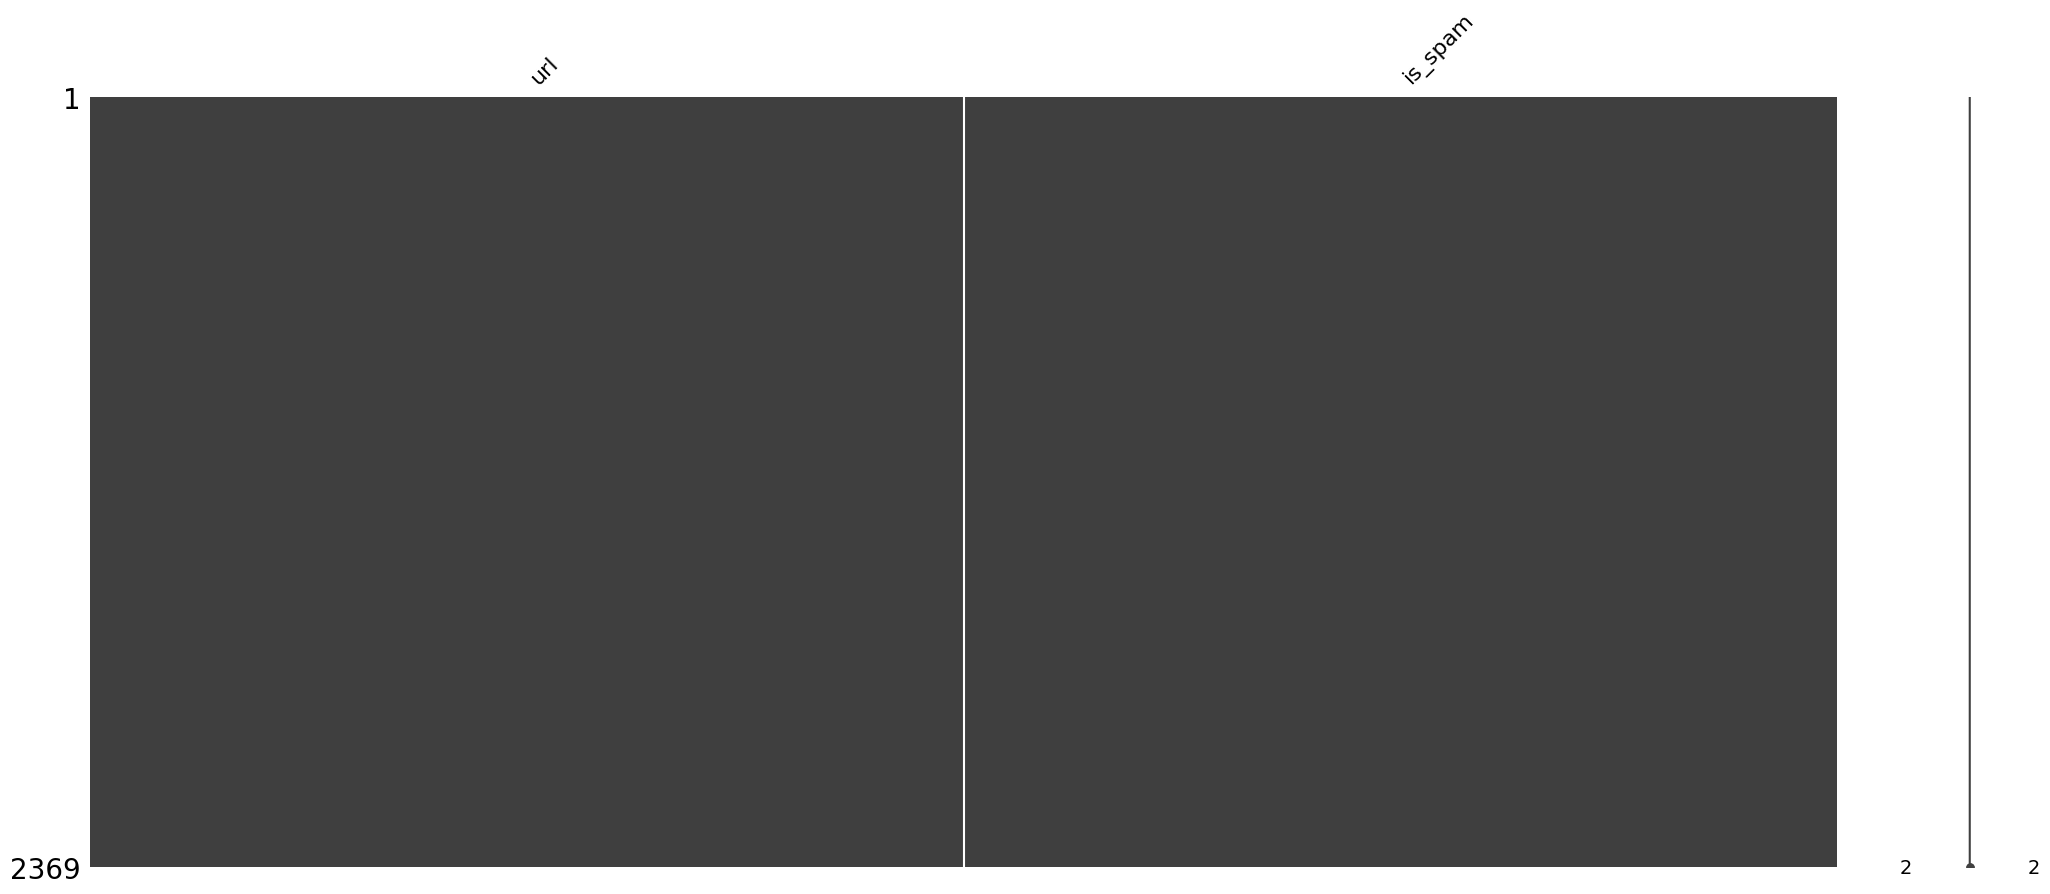

In [12]:
msno.matrix(df_spam)

### 2. Binary encoding:

In [13]:
df_spam["is_spam"] = df_spam["is_spam"].astype(str).str.lower().isin(["true", "1", "yes"]).astype(int)
df_spam.head(7)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1
5,https://www.brookings.edu/interactives/reopeni...,0
6,https://www.reuters.com/investigates/special-r...,0


### 3. Data processing

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http", "", text)
    text = re.sub(r"https", "", text)
    text = re.sub(r"www", "", text)
    text = re.sub(r"com", "", text)
    text = re.sub(r"[^a-záéíóúñ]", " ", text)
    text = re.sub(r"\b[a-záéíóúñ]\b", "", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text

In [15]:
df_spam["url"] = df_spam["url"].apply(preprocess_text)
df_spam["url"].head(7)

0               briefingday us list manage unsubscribe
1                                                hvper
2                                          briefingday
3                                 briefingday mentform
4                                      briefingday fan
5    brookings edu interactives reopening america a...
6    reuters investigates special report health cor...
Name: url, dtype: object

### 4. Data lemmatisation and stop words elimination 

Is the process to simplifying words to their base form. It means that words with different forms but the same semantic core are trated as single word.

In addition, by taking advantage of lemmatisation, we will eliminate stopwords, wich are words that we consider irrelevant for text analysis because they appear very frequently in lenguage and do not provide meaningful information. We cando this with our own list of words to eliminate or by using external libraries.

In [16]:
download("wordnet")
lemmatizer = WordNetLemmatizer()
download("stopwords")
stop_words = stopwords.words("english")
def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df_spam["url"] = df_spam["url"].apply(lambda x: lemmatize_text(x.split()))
df_spam.head(7)

,url,is_spam
0,"[briefingday, list, manage, unsubscribe]",1
1,[hvper],1
2,[briefingday],1
3,"[briefingday, mentform]",0
4,"[briefingday, fan]",1
5,"[brookings, edu, interactives, reopening, amer...",0
6,"[reuters, investigates, special, report, healt...",0


### 5. Word cloud graphing

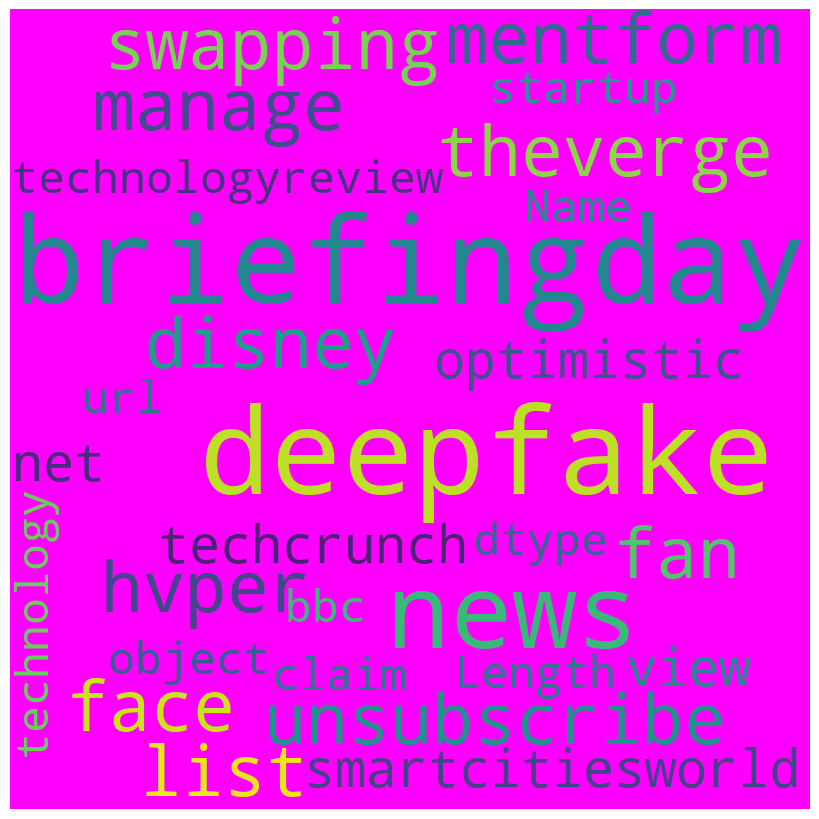

In [18]:
wordcloud = WordCloud(width=800, height=800, background_color="fuchsia", max_words=1000, min_font_size=20, random_state = 18).generate(str(df_spam["url"]))
fig = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 6. Vectorise the data frame

The final step before training the model is to convert into numbers, as model can not be trained with textual categories.

In [19]:
tokens_list = df_spam["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df_spam["is_spam"]

X[:7]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(7, 659))

"TfidfVectorizer" converts a collection of raw text documents into a matrix of TF-IDF features.
It is a measure that quatifies the importance of a word in a document relative to a corpus. It consists of two terms:

- TF (Term Frecuency): This is the frequency of a word in a document.
- IDF (Inverse Document Frequency): This measures the importance of the term in the corpus. A term that appears in many documents may not be as informative.

Therefore, by using TfidfVectorizer, we transform a collection of text documents into a numerical matrix that represents the relative importance of each word in each document, relative to the entire corpus.

This matrix is commonly used as an input for machine learning algorithms, especially in natural language processing tasks such as text classification.

In [20]:
df_spam_vectorized = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())
print(df_spam_vectorized)

       aa   ab  abcnews  abortion   ac  account  acebbd  action  activist  \
0     0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
1     0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
2     0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
3     0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
4     0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
...   ...  ...      ...       ...  ...      ...     ...     ...       ...   
2364  0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
2365  0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
2366  0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
2367  0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   
2368  0.0  0.0      0.0       0.0  0.0      0.0     0.0     0.0       0.0   

       ad  ...  wsj  wwdc  year  york  young  youre  youtu  youtube  zone  

In [21]:
X.shape

(2369, 659)

In [22]:
(df_spam_vectorized > 0).any()

aa          True
ab          True
abcnews     True
abortion    True
ac          True
            ... 
youre       True
youtu       True
youtube     True
zone        True
zoox        True
Length: 659, dtype: bool

### 7. Modeling

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 18)
model = SVC(kernel = "linear", random_state = 18)
model.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### 8. Prediction

In [24]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

### 9. Accuracy

In [25]:
accuracy_score(y_test, y_pred)

0.9219409282700421

### 10. Testing model

In [32]:
new_url = "https://outlook.office.com/meeting-at-the-office"
processed_new_url = preprocess_text(new_url)
lemmatized_new_url = lemmatize_text(processed_new_url.split())
lemmatized_new_url = " ".join(lemmatized_new_url)
vectorized_new_url = vectorizer.transform([lemmatized_new_url]).toarray()
prediction = model.predict(vectorized_new_url)
print(f"Prediction: {'Spam' if prediction[0] == 1 else 'Not Spam'}")

Prediction: Not Spam


In [33]:
lemmatized_new_url

'outlook office meeting office'

In [34]:
len(vectorized_new_url[0]), vectorized_new_url

(659,
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 

### 11. Optimisation model 
# No ejecuted. If is not necessary, please ignore.